In [ ]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import warnings

warnings.filterwarnings("ignore")

## Data Access

### servers, servers everywhere and not a bit to flip

![](https://imgs.xkcd.com/comics/digital_data.png)


## whoami

`ocefpaf` (Filipe Fernandes)

- Physical Oceanographer
- Data Plumber
- Code Janitor
- CI babysitter
- Amazon-Dash-Button for conda-forge


## My day job: IOOS

![](https://raw.githubusercontent.com/ocefpaf/2018-SciPy-talk/gh-pages/images/IOOS-RAs.jpg)


## Big or small we need data!

- There are various sources: variety of servers, APIs, and web services. Just to
  list a few: OPeNDAP, ERDDAP, THREDDS, ftp, http(s), S3, LAS, etc.

![](https://imgs.xkcd.com/comics/data_pipeline.png)


## Feedback

As you suffer from my tutorial on Data Access I'd love that you keep the following questions in mind so we can improve the tutorials. Should this tutorial focus on?

- Leveraging metadata for finding data and exploring data?
- Software packages to access, slice, and dice data?
- Data sources?
- None of the above, we don't need this tutorial!

## Web Services/Type of servers

| Data Type                              | Web Service | Response    |
| -------------------------------------- | ----------- | ----------- |
| In-situ data<br>(buoys, stations, etc) | OGC SOS     | XML/CSV     |
| Gridded data (models, satellite)       | OPeNDAP     | Binary      |
| Raster Images                          | OGC WMS     | GeoTIFF/PNG |
| ERDDAP                                 | Restful API | \*          |

- Your imagination is the limit!


## What are we going to see in this tutorial?

Browse and access data from:

1. ERDDAP
2. OPeNDAP
3. ~~SOS~~
4. WMS
5. CSW and CKAN\*


\* There are many examples on CSW in [the IOOS code lab] jupyter-book (https://ioos.github.io/ioos_code_lab/content/intro.html).

## 1) ERDDAP

### Learning objectives:

- Explore an ERDDAP server with the python interface (erddapy);
- Find a data for a time/region of interest;
- Download the data with a familiar format and create some plots.


## What is ERDDAP?

- Flexible outputs: .html table, ESRI .asc and .csv, .csvp, Google Earth .kml,
  OPeNDAP binary, .mat, .nc, ODV .txt, .tsv, .json, and .xhtml
- RESTful API to access the data
- Standardize dates and time in the results
- Server-side searching and slicing


In [17]:
from erddapy import ERDDAP

server = "http://erddap.dataexplorer.oceanobservatories.org/erddap"

e = ERDDAP(server=server, protocol="tabledap")

In [17]:
from erddapy import ERDDAP

server = "http://erddap.dataexplorer.oceanobservatories.org/erddap"

e = ERDDAP(server=server, protocol="tabledap")

### What services are available in the server?


In [22]:
import pandas as pd

df = pd.read_csv(
    e.get_search_url(
        response="csv",
        search_for="all",
    )
)

In [23]:
print(
    f'We have {len(set(df["tabledap"].dropna()))} '
    f'tabledap, {len(set(df["griddap"].dropna()))} '
    f'griddap, and {len(set(df["wms"].dropna()))} wms.'
)

We have 600 tabledap, 0 griddap, and 0 wms.


### Let's query all the datasets that have the _standard_name_ of _sea_water_practical_salinity_.


In [21]:
url = e.get_categorize_url(
    categorize_by="standard_name",
    value="sea_water_temperature",
    response="csv",
)

df = pd.read_csv(url)
dataset_ids = df.loc[~df["tabledap"].isnull(), "Dataset ID"].tolist()

dataset_ids_list = "\n".join(dataset_ids)
print(f"Found {len(dataset_ids)} datasets")

Found 336 datasets


### Let us narrow our search to deployments that within a lon/lat/time extent.


In [40]:
from ipyleaflet import FullScreenControl, Map, Rectangle

min_lon, max_lon = -92.6828, -88.5754
min_lat, max_lat = 2.3495, -2.07455

rectangle = Rectangle(bounds=((min_lat, min_lon), (max_lat, max_lon)))

m = Map(
    center=((min_lat + max_lat) / 2, (min_lon + max_lon) / 2),
    zoom=6,
)

m.add_layer(rectangle)
m.add_control(FullScreenControl())

In [41]:
m

Map(center=[0.137475, -90.6291], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [42]:
kw = {
    "min_time": "2004-01-10T00:00:00Z",
    "max_time": "2004-31-10T00:00:00Z",
    "min_lon": min_lon,
    "max_lon": max_lon,
    "min_lat": min_lat,
    "max_lat": max_lat,
    "standard_name": "sea_water_temperature",
}

In [43]:
search_url = e.get_search_url(response="csv", **kw)
search = pd.read_csv(search_url)
dataset_ids = search["Dataset ID"].values

dataset_ids_list = "\n".join(dataset_ids)

DateParseError: month must be in 1..12

In [ ]:
print(f"Found {len(dataset_ids)} Datasets:\n{dataset_ids_list}")

In [52]:

temp = "sea_water_temperature_profiler_depth_enabled"

e.dataset_id = dataset_ids[0]

e.variables = [
    "z",
    "latitude",
    "longitude",
   
    temp,
    "time",
]

url = e.get_download_url()
print(url)

http://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-ce01issm-rid16-02-flortd000.html?z,latitude,longitude,sea_water_temperature_profiler_depth_enabled,time


In [53]:
import pandas as pd

df = e.to_pandas(index_col="time (UTC)", parse_dates=True).dropna()

df.head()

HTTPError: Error {
    code=400;
    message="Bad Request: Query error: Unrecognized variable=\"sea_water_temperature_profiler_depth_enabled\".";
}


Exercise: experiment with the `e.to_xarray()` method. Think about why/where use
one or the other?


In [54]:
import matplotlib.pyplot as plt

subset = df.loc[df["z (m)"] == df["z (m)"].min()]

fig, ax = plt.subplots(figsize=(13, 3.75))
subset[f"{sal} (1e-3)"]["2016"].dropna().plot(ax=ax)

KeyError: 'z (m)'

In [ ]:
import gsw
import numpy as np


def plot_ts():
    fig, ax = plt.subplots(figsize=(5, 5))

    s = np.linspace(0, 42, 100)
    t = np.linspace(-2, 40, 100)

    s, t = np.meshgrid(s, t)
    sigma = gsw.sigma0(s, t)

    cnt = np.arange(-7, 40, 5)
    cs = ax.contour(s, t, sigma, colors="gray", levels=cnt)
    ax.clabel(cs, fontsize=9, inline=1, fmt="%2i")

    ax.set_xlabel("Salinity [g kg$^{-1}$]")
    ax.set_ylabel("Temperature [$^{\circ}$C]")
    ax.scatter(df[f"{sal} (1e-3)"], df[f"{temp} (degree_Celsius)"], s=10, alpha=0.25)

    ax.grid(True)
    ax.axis([20, 40, 4, 26])
    return fig, ax

In [ ]:
fig, ax = plot_ts()

In [ ]:
responses = ["mat", "json", "ncCF", "ncCFHeader"]

for response in responses:
    print(f"{e.get_download_url(response=response)}\n")

Exercise: explore the web interface for the OOI server URL:

http://erddap.dataexplorer.oceanobservatories.org/erddap/index.html

or the IOOS glider dac:

https://gliders.ioos.us/erddap

and find a dataset of interested, download a format that you are familiar with
and plot it (using the web interface or the Python, your choice).


## 2) OPeNDAP

### Learning objectives:

- Open model data from a THREDDS server via OPeNDAP with `xarray`;
- Discuss the differences with an `erddapy` request;
- Plot it using `xarray` interface.


In [4]:
import cf_xarray
import xarray as xr

url = (
    "http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best"
)
ds = xr.open_dataset(url)
ds.cf


- CF Roles:   grid_topology: ['grid']

Coordinates:
- CF Axes: * Z: ['s_rho', 's_w']
           * T: ['ocean_time', 'time']
             X, Y: n/a

- CF Coordinates:   longitude: ['lon_psi', 'lon_rho', 'lon_u', 'lon_v']
                    latitude: ['lat_psi', 'lat_rho', 'lat_u', 'lat_v']
                  * vertical: ['s_rho', 's_w']
                  * time: ['ocean_time', 'time']

- Cell Measures:   area, volume: n/a

- Standard Names:   forecast_reference_time: ['time_run']
                    latitude: ['lat_psi', 'lat_rho', 'lat_u', 'lat_v']
                    longitude: ['lon_psi', 'lon_rho', 'lon_u', 'lon_v']
                  * ocean_s_coordinate_g2: ['s_rho', 's_w']
                  * time: ['time']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   barotropic_eastward_sea_water_velocity: ['ubar_eastward']
                    barotropic_northward_sea_water_velocity: ['vbar_northward']
                    eastward_sea_water_velocity

In [5]:
variable = "sea_water_potential_temperature"
time = "2022-08-10"
surface = -1

selection = ds.cf[variable].sel(time="2022-08-10").isel(s_rho=surface)

/opt/conda/lib/python3.9/site-packages/cf_xarray/accessor.py:1638: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


/opt/conda/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


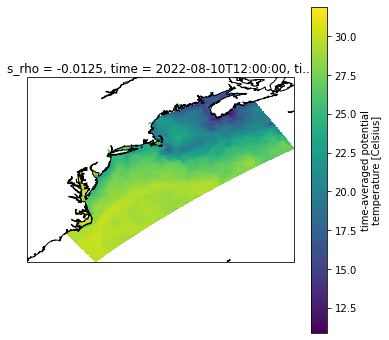

In [6]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

selection.plot(
    ax=ax,
    x="lon_rho",
    y="lat_rho",
)

ax.coastlines()

## 3) ~~SOS~~

### Learning objectives:

- Use searvey to obtain CO-OPS data


In [ ]:
import shapely
from searvey import coops

secoora = shapely.geometry.box(-87.4, 24.25, -74.7, 36.7)
df = coops.coops_stations_within_region(secoora)
df

In [ ]:
df.loc[df["name"] == "Duck"]

In [ ]:
from datetime import datetime, timedelta

from searvey.coops import COOPS_Station

station = COOPS_Station("Duck")

ds = station.product(
    "water_level",
    start_date=datetime.today() - timedelta(15),
    end_date=datetime.today(),
)

ds["v"].plot()

## 4) WMS

### Learning objectives:

- Add a WMS layer to an interactive map. ("Hurricane viz widget.")


In [8]:
from ipyleaflet import FullScreenControl, Map, WMSLayer, basemaps
from ipywidgets import SelectionSlider
from traitlets import Unicode

time_options = [
    "13:00",
    "13:30",
    "14:00",
    "14:30",
    "15:00",
    "15:30",
    "16:00",
    "16:30",
    "17:00",
    "17:30",
    "18:00",
    "18:30",
]

slider = SelectionSlider(description="Time:", options=time_options)


def update_wms(change):
    time_wms.time = "2020-07-25T{}".format(slider.value)


slider.observe(update_wms, "value")


class TimeWMSLayer(WMSLayer):
    time = Unicode("").tag(sync=True, o=True)

In [7]:
time_wms = TimeWMSLayer(
    url="https://urs.earthdata.nasa.gov/",
    layers="nexrad-n0r-wmst",
    time="2020-07-25T13:00:00Z",
    format="image/png",
    transparent=True,
    attribution="Weather data © 2012 IEM Nexrad",
)
m = Map(basemap=basemaps.CartoDB.Positron, center=(30, -88), zoom=5)
m.add_layer(time_wms)
m.add_control(FullScreenControl())

In [ ]:
m

In [ ]:
slider

## 5) Catalog Service Web (CSW)

### Is there a canonical source for data?


![](https://i.kym-cdn.com/photos/images/newsfeed/001/093/557/142.gif)


Well, kind of... The closet thing is are data catalogs like the [IOOS CSW catalog](https://data.ioos.us/) or [pangeo-forge](https://pangeo-forge.readthedocs.io/en/latest/).

## Catalog Service for the Web (CSW)

- A single source to find endpoints
- Nice python interface:<br>`owslib.csw.CatalogueServiceWeb`
- Advanced filtering:<br>`owslib.fes`


![](https://raw.githubusercontent.com/ocefpaf/2018-SciPy-talk/gh-pages/images/IOOS.svg)


## For more complex examples on how to find data in the catalog please check the IOOS code gallery:

[https://ioos.github.io/ioos_code_lab/content/intro.html](https://ioos.github.io/ioos_code_lab/content/intro.html)


## Where to find data?


Curated list of ERDDAP servers:
https://github.com/IrishMarineInstitute/awesome-erddap

Environmental Data Service (EDS) model viewer: https://eds.ioos.us

Exploring THREDDS servers: https://unidata.github.io/siphon/latest


## Extras: how does this all work?


## Standards!

![](https://imgs.xkcd.com/comics/standards.png)


## Bad example


In [14]:
import cftime
import nc_time_axis
from netCDF4 import Dataset

url = "https://urs.earthdata.nasa.gov/"
nc = Dataset(url)

temp = nc["temperature"][:]
times = nc["time"]
temp[temp <= -9999] = np.NaN
t = cftime.num2date(times[:], times.units, calendar=times.calendar)

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!DOCTYPE^ html><!--[if lt IE 7]><html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]--><!--[if IE 7]><html class="no-js lt-ie9 lt-ie8"> <![endif]--><!--[if IE 8]><html class="no-js lt-ie9"> <![endif]--><!--[if gt IE 8]><!--><html lang="en" class="no-js"><!--<![endif]--> <head><script id="f5_cspm">(function(){var f5_cspm={f5_p:'FLGCEIGMGKNHNPNODLPEEAINFNGMIALGDANIECMGEPCIMHDAMLDPMMHLAFDGNBPFGKLBCHDKAAAHBNFJIOGAPBNAAADDCOKOMKNICJHKOJCLBGBEOJHAAAIBLLJJNIAK',setCharAt:function(str,index,chr){if(index>str.length-1)return str;return str.substr(0,index)+chr+str.substr(index+1);},get_byte:function(str,i){var s=(i/16)|0;i=(i&15);s=s*32;return((str.charCodeAt(i+16+s)-65)<<4)|(str.charCodeAt(i+s)-65);},set_byte:function(str,i,b){var s=(i/16)|0;i=(i&15);s=s*32;str=f5_cspm.setCharAt(str,(i+16+s),String.fromCharCode((b>>4)+65));str=f5_cspm.setCharAt(str,(i+s),String.fromCharCode((b&15)+65));return str;},se

OSError: [Errno -72] NetCDF: Malformed or inaccessible DAP2 DDS or DAP4 DMR response: b'https://urs.earthdata.nasa.gov/'

In [10]:
mask = (t >= datetime(2008, 1, 1)) & (t <= datetime(2008, 12, 31))

NameError: name 't' is not defined

NameError: name 't' is not defined

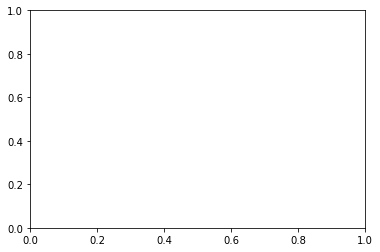

In [11]:
fig, ax = plt.subplots()
ax.plot(t[mask], temp[:, 0][mask], ".")

## Good example


In [15]:
import xarray as xr

ds = xr.open_dataset(url)
temp = ds["temperature"]

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!DOCTYPE^ html><!--[if lt IE 7]><html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]--><!--[if IE 7]><html class="no-js lt-ie9 lt-ie8"> <![endif]--><!--[if IE 8]><html class="no-js lt-ie9"> <![endif]--><!--[if gt IE 8]><!--><html lang="en" class="no-js"><!--<![endif]--> <head><script id="f5_cspm">(function(){var f5_cspm={f5_p:'ONFGEGOBFEPCGOEGAEOEDGNJBIFFEGMGCKIPPANOJPAKMAALLNKMIKGGOGOMPEGEJFHBLODPAADCDIIPJEDAKGHPAALINHOIIAJOONJLKJFHJFOBOGCENJCKDAIDEOAH',setCharAt:function(str,index,chr){if(index>str.length-1)return str;return str.substr(0,index)+chr+str.substr(index+1);},get_byte:function(str,i){var s=(i/16)|0;i=(i&15);s=s*32;return((str.charCodeAt(i+16+s)-65)<<4)|(str.charCodeAt(i+s)-65);},set_byte:function(str,i,b){var s=(i/16)|0;i=(i&15);s=s*32;str=f5_cspm.setCharAt(str,(i+16+s),String.fromCharCode((b>>4)+65));str=f5_cspm.setCharAt(str,(i+s),String.fromCharCode((b&15)+65));return str;},se

OSError: [Errno -72] NetCDF: Malformed or inaccessible DAP2 DDS or DAP4 DMR response: b'https://urs.earthdata.nasa.gov/'

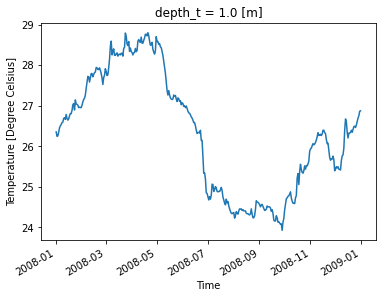

In [16]:
temp.sel(depth_t=1.0, time="2008").plot()